### Helping a Technology Firm After a Hack:
A large technology company needs your help because they've recently been hacked! Fortunately, their forensic engineers were able to gather valuable data about the attack sessions, including details such as session duration, locations, typing speed, and more.

**Features of the Hack Sessions**
- Session_Connection_Time: The length of time each hacking session lasted, measured in minutes.
- Bytes Transferred: The amount of data (in megabytes) transferred during the session.
- Kali_Trace_Used: An indicator showing whether the hacker was using Kali Linux (a popular tool used for penetration testing and hacking).
- -Servers_Corrupted: The number of servers that were compromised during the attack.
- Pages_Corrupted: The number of pages that were illegally accessed during the attack.
- Location: The geographical location where the attack appeared to originate from. (Note: This feature might be unreliable since hackers typically use VPNs to hide their true location.)
- WPM_Typing_Speed: The hacker's estimated typing speed, calculated from the session logs.

The technology firm suspects that there are three potential hackers involved in the attack. They are certain that the first two hackers were involved, but they are unsure if the third suspect had anything to do with the attacks.

The hackers traded off attacks, meaning each hacker should have roughly the same number of sessions.

Example: If there were 100 attacks, then:
- In a 2-hacker situation: Each hacker should have around 50 attacks.
- In a 3-hacker situation: Each hacker should have around 33 attacks.

Your task is to help the company figure out:
1. Whether or not the third suspect was involved.
2. How many distinct groups (hackers) can be identified based on the collected session data.

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("Homework 11").getOrCreate()

In [3]:
url = "https://raw.githubusercontent.com/oakabc/DEA/main/11%20-%20Clustering/hack_data.csv"
df = pd.read_csv(url)
dataset = spark.createDataFrame(df)

In [4]:
dataset.show()

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|            70.8|
|                   20.0|            408.5|              0|             3.57

In [5]:
dataset = dataset.withColumn("Kali_Trace_Used", col("Kali_Trace_Used").cast("int"))

In [6]:
features = ['Session_Connection_Time', 'Bytes Transferred', 'Kali_Trace_Used', 'Servers_Corrupted', 'Pages_Corrupted', 'WPM_Typing_Speed']
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
dataset_vector = vector_assembler.transform(dataset)

In [7]:
dataset_vector.show()

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|            features|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|[8.0,391.09,1.0,2...|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|[20.0,720.99,0.0,...|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|[31.0,356.32,1.0,...|
|                    2.0|           228.08|              1|             2.48|     

In [9]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(dataset_vector)
dataset_scaled = scaler_model.transform(dataset_vector)

In [10]:
# Run KMeans for both k=2 and k=3
results = []
for k in [2, 3]:
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=42)
    model = kmeans.fit(dataset_scaled)
    predictions = model.transform(dataset_scaled)

    # Calculate WSSSE (Within Set Sum of Squared Errors)
    cost = model.summary.trainingCost

    # Get cluster counts and convert to pandas for analysis
    cluster_counts = predictions.groupBy("prediction").count().toPandas()

    # Calculate evenness of distribution
    total_sessions = predictions.count()
    expected_count = total_sessions / k
    variance = sum((row['count'] - expected_count)**2 for _, row in cluster_counts.iterrows())

    results.append({
        'k': k,
        'cost': cost,
        'cluster_counts': cluster_counts,
        'variance': variance
    })

    print(f"\nK={k} Clustering Results:")
    print(f"WSSSE (Cost): {cost:.2f}")
    print("Cluster distribution:")
    for _, row in cluster_counts.iterrows():
        print(f"  Cluster {row['prediction']}: {row['count']} sessions ({row['count']/total_sessions*100:.1f}%)")


K=2 Clustering Results:
WSSSE (Cost): 601.77
Cluster distribution:
  Cluster 0: 167 sessions (50.0%)
  Cluster 1: 167 sessions (50.0%)

K=3 Clustering Results:
WSSSE (Cost): 434.76
Cluster distribution:
  Cluster 0: 167 sessions (50.0%)
  Cluster 1: 88 sessions (26.3%)
  Cluster 2: 79 sessions (23.7%)


([<matplotlib.axis.XTick at 0x79b861641050>,
 [Text(2, 0, '2'), Text(3, 0, '3')])

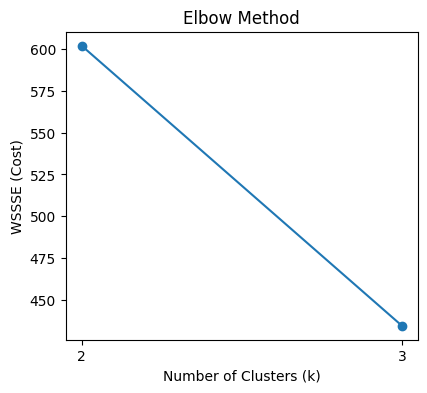

In [11]:
# Plot cost comparison
k_values = [r['k'] for r in results]
costs = [r['cost'] for r in results]
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_values, costs, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSSSE (Cost)')
plt.title('Elbow Method')
plt.xticks(k_values)

In [12]:
# Analyze results to determine optimal k
cost_improvement = (results[0]['cost'] - results[1]['cost']) / results[0]['cost']
distribution_ratio = results[0]['variance'] / results[1]['variance']

print("\nAnalysis Metrics:")
print(f"Cost improvement from k=2 to k=3: {cost_improvement:.2%}")
print(f"Distribution variance ratio (k=2/k=3): {distribution_ratio:.2f}")


Analysis Metrics:
Cost improvement from k=2 to k=3: 27.75%
Distribution variance ratio (k=2/k=3): 0.00


In [13]:
# Make final determination
# Using cost improvement threshold and distribution evenness
if cost_improvement > 0.15:  # Significant improvement in cost
    optimal_k = 3
    print("\nConclusion: Three hackers were likely involved.")
    print("The third suspect was likely involved in the attacks.")
elif distribution_ratio > 1.5:  # k=3 has much more even distribution
    optimal_k = 3
    print("\nConclusion: Three hackers were likely involved.")
    print("The third suspect was likely involved in the attacks.")
else:
    optimal_k = 2
    print("\nConclusion: Two hackers were likely involved.")
    print("The third suspect was likely NOT involved in the attacks.")


Conclusion: Three hackers were likely involved.
The third suspect was likely involved in the attacks.


In [14]:
spark.stop()